# Single aperture exploration

Check aperture 11511 for:

* is the signal the same in the single night detrend vs multi-night detrend
* is the signal the same with no flat
* is the signal the same with the flat without vignetting

Also check other similar apertures

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import fitsio
import seaborn as sns
from collections import namedtuple
from scipy.stats import binned_statistic
from astropy.stats import sigma_clip

sns.set(style='ticks', context='talk', palette='Set2')
colours = sns.color_palette()

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [41]:
def bin_1d(x, y, nbins):
    by, bx, _ = binned_statistic(x, y, bins=nbins)
    centre = (bx[:-1] + bx[1:]) / 2.
    return centre, by

In [42]:
aperture = 11511

files = {
    'single night detrend': ('../data/20150911-ng2000-802-custom-flat-high-quality.fits', 'tamflux'),
    'multi night detrend': ('../data/20150911-ng2000-802-sysrem-all.fits', 'tamflux'),
    'multi night full': ('../data/tamout.fits', 'flux'),
    'single night full': ('/ngts/pipedev/ParanalOutput/detrending_subset/ng2000-802.fits', 'tamflux'),
    }

In [43]:
LightcurveData = namedtuple('LightcurveData', ['hjd', 'flux', 'sc', 'night'])

In [44]:
lightcurve_data = {}

for description in files:
    (filename, hdu) = files[description]
    with fitsio.FITS(filename) as infile:
        hjd = infile['hjd'][aperture:aperture + 1, :].ravel()
        flux = infile[hdu][aperture:aperture + 1, :].ravel()
        imagelist = infile['imagelist'].read()
    sc = sigma_clip(flux, iters=2)
    lightcurve_data[description] = LightcurveData(hjd=hjd, flux=flux, sc=sc, night=imagelist['NIGHT'])

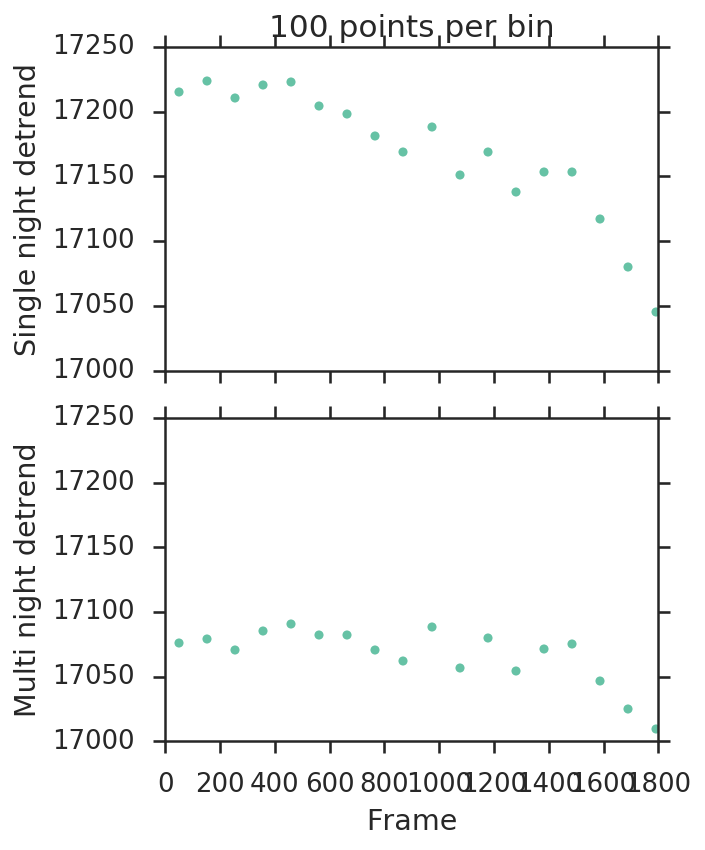

In [45]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 6))
for d, ax in zip(['single night detrend', 'multi night detrend'], axes):
    data = lightcurve_data[d]
    lc = data.sc
    bx, by = bin_1d(np.arange(lc.size), lc, lc.size / 100)
    ax.plot(bx, by, '.')
axes[0].set(ylabel='Single night detrend', title='100 points per bin')
axes[1].set(ylabel='Multi night detrend', xlabel='Frame')
fig.tight_layout()

I've plotted this with a smaller width deliberately to emphasise the gradient. There is a hint of a gradient to the lower panel also, especially at the end but it is much smaller.

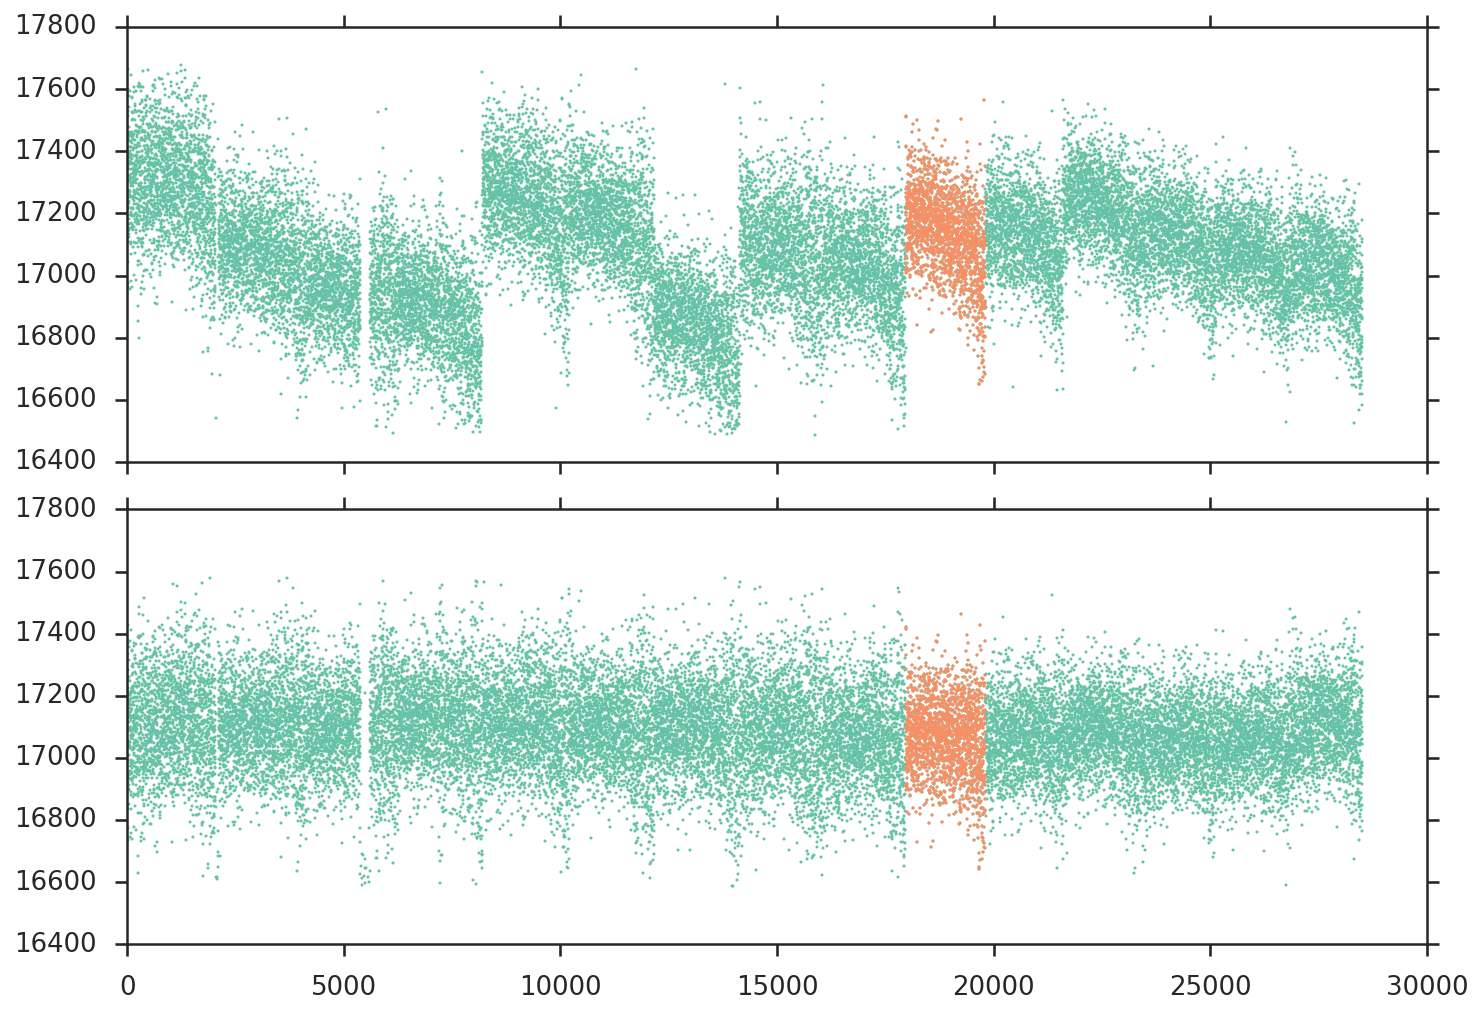

In [46]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
for d, ax in zip(['single night full', 'multi night full'], axes):
    data = lightcurve_data[d]
    ind = data.night == b'20150911'
    frames = np.arange(data.sc.size)
    ax.plot(frames, data.sc, '.', ms=3)
    ax.plot(frames[ind], data.sc[ind], '.', ms=3)
fig.tight_layout()

The long term behaviour is completely different for the different sysrem runs. It is possible that the downward trend that remains is part of the long term variability that is now present in the lightcurve.